# Features Selection for Regression with *Feature-Engine*

In [90]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 99
import matplotlib.pyplot as plt

# LOAD DATA

In [143]:
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name="house_prices", as_frame=True)
col_y = dataset["target_names"]
cols_x = dataset["feature_names"]
data = dataset["frame"]
data.shape

(1460, 81)

## DATA PREPARATION

In [144]:
# missing values imputation
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import DropMissingData
# categorical variables enconding
from feature_engine.encoding import OrdinalEncoder

In [145]:
# remove columns with to much NaN values
cols_drop = list(data.columns[(data.isnull().sum() / len(data) > 0.5).values])
data.drop(cols_drop, axis = 1, inplace = True)

In [146]:
# columns names collection by type of variable
cols_num = data.select_dtypes(include=['float64']).columns.tolist()                                       
cols_cat = data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()         
cols_int = data.select_dtypes(include=['int64']).columns.tolist()
cols_x = [c for c in cols_num + cols_cat]
print(len(cols_num), len(cols_cat), len(cols_int))

38 39 0


In [147]:
# missing values imputation: numerical
median_imputer = MeanMedianImputer(
                   imputation_method='median',
                   variables=cols_num
                   )
data = median_imputer.fit_transform(data)
# missing values imputation: categorical
imputer = CategoricalImputer(variables=cols_cat)
data = imputer.fit_transform(data)

In [148]:
# categorical variables enconding
from feature_engine.encoding import OrdinalEncoder
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=cols_cat)
# fit the encoder
data_encoded = encoder.fit_transform(data, data[col_y])

# [FEATURES SELECTION](https://feature-engine.readthedocs.io/en/1.3.x/user_guide/selection/index.html)

In [149]:
# selection based on feature characteristics
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import DropHighPSIFeatures
# selection based on model performance
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.selection import SelectByTargetMeanPerformance
from feature_engine.selection import RecursiveFeatureElimination

### based on feature characteristics

In [150]:
# DropConstantFeatures (Allows Categorical variables, Allows NA)
fcte = DropConstantFeatures(tol=0.98, variables = cols_x, missing_values = 'ignore')
fcte.fit(data)
print(list(fcte.features_to_drop_))

['LowQualFinSF', '3SsnPorch', 'PoolArea', 'Street', 'Utilities', 'Condition2', 'RoofMatl']


In [151]:
# SmartCorrelatedSelection (NOT Allows Categorical variables, Allows NA)
fcorr1 = SmartCorrelatedSelection(variables=cols_num, method='pearson', threshold=0.8, missing_values="ignore", selection_method="variance")
fcorr2 = SmartCorrelatedSelection(variables=cols_num, method='kendall', threshold=0.8, missing_values="ignore", selection_method="variance")
fcorr3 = SmartCorrelatedSelection(variables=cols_num, method='spearman', threshold=0.8, missing_values="ignore", selection_method="variance")
fcorr1.fit(data)
fcorr2.fit(data)
fcorr3.fit(data)
if len(fcorr1.features_to_drop_):
    print('pearson',fcorr1.features_to_drop_,fcorr1.correlated_feature_sets_)
if len(fcorr2.features_to_drop_):
    print('kendall',fcorr2.features_to_drop_, fcorr2.correlated_feature_sets_)
if len(fcorr3.features_to_drop_):
    print('spearman',fcorr3.features_to_drop_, fcorr3.correlated_feature_sets_)

pearson ['1stFlrSF', 'TotRmsAbvGrd', 'GarageCars'] [{'TotalBsmtSF', '1stFlrSF'}, {'TotRmsAbvGrd', 'GrLivArea'}, {'GarageArea', 'GarageCars'}]
spearman ['OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars'] [{'OverallQual', 'SalePrice'}, {'GarageYrBlt', 'YearBuilt'}, {'TotalBsmtSF', '1stFlrSF'}, {'TotRmsAbvGrd', 'GrLivArea'}, {'GarageArea', 'GarageCars'}]


In [152]:
# DropHighPSIFeatures (NOT Allows Categorical variables, Allows NA)
cat_ref_col = "MSZoning"
fpsi = DropHighPSIFeatures(variables = cols_num, split_col=cat_ref_col, split_distinct=True, missing_values="ignore")
fpsi.fit(data)
print(list(fcte.features_to_drop_))

['LowQualFinSF', '3SsnPorch', 'PoolArea', 'Street', 'Utilities', 'Condition2', 'RoofMatl']


<AxesSubplot:xlabel='SalePrice', ylabel='Proportion'>

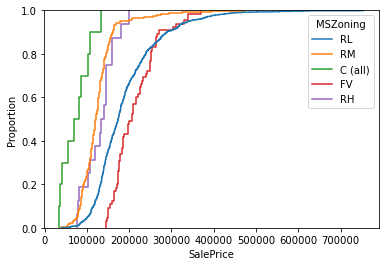

In [153]:
import seaborn as sns
sns.ecdfplot(data=data, x=col_y[0], hue=cat_ref_col)

### selection based on model performance

In [154]:
# SelectBySingleFeaturePerformance (NOT Allows Categorical variables, NOT Allows NA)
from sklearn.linear_model import LinearRegression, HuberRegressor
fsel1 = SelectBySingleFeaturePerformance(estimator=LinearRegression(), scoring="r2", cv=5, threshold=0.01, variables = cols_num)
fsel2 = SelectBySingleFeaturePerformance(estimator=HuberRegressor(), scoring="r2", cv=5, threshold=0.01, variables = cols_num)
fsel1.fit(data, data[col_y])
fsel2.fit(data, data[col_y])
print(fsel1.features_to_drop_)
print(fsel2.features_to_drop_)

['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['Id', 'MSSubClass', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [155]:
# SelectByTargetMeanPerformance (Allows Categorical variables, NOT Allows NA)
selcat = SelectByTargetMeanPerformance(
    variables=cols_x,
    scoring="r2", #"roc_auc",
    threshold= None, # If the threshold if left to None, it selects features which performance is bigger than the mean performance of all features.
    #threshold=0.01, 
    bins=5,
    strategy="equal_frequency",
    cv=3,
    regression=True)
selcat.fit(data, data[col_y])
print(selcat.features_to_drop_)
print([c for c in cols_num if not c in list(selcat.features_to_drop_)])
print([c for c in cols_cat if not c in list(selcat.features_to_drop_)])

['Id', 'MSSubClass', 'LotFrontage', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'BsmtExposure', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice']
['Utilities', 'Neighborhood', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', '

In [175]:
# RecursiveFeatureElimination (RFE) (NOT Allows Categorical variables, NOT Allows NA)
# NOTE: Using as estimator a tree based algorithm, it is possible categorical variables previously ordinally encoded
from sklearn.ensemble import RandomForestRegressor
tr2 = RecursiveFeatureElimination(estimator=RandomForestRegressor(), scoring="r2", cv=3, variables = cols_x, threshold = 0.01)
tr2.fit(data_encoded, data_encoded[col_y])
print(tr2.features_to_drop_,[c for c in cols_x if not c in list(tr2.features_to_drop_)])

ValueError: All features have been removed. Try reducing the threshold.

In [181]:
# RecursiveFeatureElimination (RFE) (NOT Allows Categorical variables, NOT Allows NA)
# NOTE: Using as estimator a tree based algorithm, it is possible categorical variables previously ordinally encoded
from sklearn.linear_model import LinearRegression
tr1 = RecursiveFeatureElimination(estimator=LinearRegression(), scoring="r2", cv=3, variables = cols_num, threshold = 0.01)
tr1.fit(data, data[col_y])
print(tr1.features_to_drop_,[c for c in cols_x if not c in list(tr1.features_to_drop_)])

ValueError: All features have been removed. Try reducing the threshold.